## **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import random

In [3]:
fretnet_json_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/merge_annotation"
cqt_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/cqt"
original_jams_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/annotation"

## **Dataset Class**

Eğer senkronizasyon öncelik haline gelirse; frame alignment, Dynamic Time Warping (DTW) vb. gibi o zaman
        
        # Zaman uyumu
        min_len = min(cqt.shape[1], tablature.shape[1])
        cqt = cqt[:, :min_len]
        tablature = tablature[:, :min_len]

kodu zaman kaymasına yol açabilir.

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import os

class CNNMultiLabelDataset(Dataset):
    def __init__(self, json_dir, cqt_dir, ignore_silence=True):
        self.cqt_dir = cqt_dir
        self.json_dir = json_dir
        self.json_files = sorted([
            os.path.join(json_dir, f) for f in os.listdir(json_dir)
            if f.endswith("_fretnet.json")
        ])
        self.ignore_silence = ignore_silence

    def __len__(self):
        return len(self.json_files)

    def __getitem__(self, idx):
        # JSON yükle
        with open(self.json_files[idx], "r") as f:
            data = json.load(f)

        # CQT yolu belirle
        filename_base = os.path.basename(self.json_files[idx]).replace("_fretnet.json", "")
        cqt_path = os.path.join(self.cqt_dir, filename_base + ".npy")

        if not os.path.exists(cqt_path):
            raise FileNotFoundError(f"CQT dosyası bulunamadı: {cqt_path}")

        # CQT ve etiketleri yükle
        cqt = np.load(cqt_path)  # [96, T]
        tablature = np.array(data["tablature"])  # [6, T]

        # Ortak minimum uzunluk
        min_len = min(cqt.shape[1], tablature.shape[1])
        cqt = cqt[:, :min_len]
        tablature = tablature[:, :min_len]

        # Mask: hangi frame'lerde geçerli nota var
        mask = (tablature >= 0).astype(np.float32)

        # Geçersiz (silence) frame'leri dummy class (0) ile değiştir
        #tablature[tablature < 0] = 0 # sessiz anların fret 0 olarak değerlendirilmesine yol açıyor.

        # Tensor dönüşümü
        cqt_tensor = torch.tensor(cqt, dtype=torch.float32).unsqueeze(0)     # [1, 96, T]
        label_tensor = torch.tensor(tablature, dtype=torch.long)            # [6, T]
        mask_tensor = torch.tensor(mask, dtype=torch.float32)               # [6, T]

        return {
            "cqt": cqt_tensor,         # Girdi spektrumu
            "label": label_tensor,     # Fret sınıfı
            "mask": mask_tensor,       # Geçerli frame maskesi
            "filename": filename_base
        }


## **Model Defination**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassCNN(nn.Module):
    def __init__(self, in_channels=1, num_strings=6, num_classes=17):
        super(MultiClassCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.3)

        # Her string için ayrı sınıf tahmini (fret index)
        self.out = nn.Conv2d(128, num_strings * num_classes, kernel_size=1)

        self.num_strings = num_strings
        self.num_classes = num_classes

    def forward(self, x):
        # x: [B, 1, 96, T]
        x = F.relu(self.bn1(self.conv1(x)))  # [B, 32, 96, T]
        x = F.relu(self.bn2(self.conv2(x)))  # [B, 64, 96, T]
        x = F.relu(self.bn3(self.conv3(x)))  # [B, 128, 96, T]

        x = self.dropout(x)
        x = self.out(x)                      # [B, 6*C, 96, T]

        x = x.mean(dim=2)                    # frekans eksenini ortala → [B, 6*C, T]

        # Yeniden şekillendir: [B, 6, C, T]
        B, _, T = x.shape
        x = x.view(B, self.num_strings, self.num_classes, T)

        return x  # logits (CrossEntropyLoss için)

| Yapı                                  | Açıklama                                       |
| ------------------------------------- | ---------------------------------------------- |
| ✅ `1D Temporal Conv` sonrası `BiLSTM` | Zamansal bağımlılığı yakalar                   |
| ✅ `Dilated Conv`                      | Daha geniş bağlamı az parametreyle öğrenir     |
| ✅ `Residual Block`                    | Öğrenmeyi kolaylaştırır (ResNet mantığı)       |
| ✅ `CBAM` ya da `SE` attention`        | Hangi feature önemli, onu vurgular             |
| ✅ `Multi-Scale Feature Fusion`        | Hem düşük hem yüksek çözünürlükte bilgi içerir |


## **Training**

In [6]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [7]:
# Hyperparams & Config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
PATIENCE = 5
SAVE_DIR = "/content/drive/MyDrive/Automatic Guitar Transcription/results/multilable_cnn"
os.makedirs(SAVE_DIR, exist_ok=True)

In [8]:
def collate_fn_pad_masked(batch):
    max_len = max(item["cqt"].shape[-1] for item in batch)

    cqts, labels, masks, filenames = [], [], [], []

    for item in batch:
        cqt = item["cqt"]            # [1, 96, T]
        label = item["label"]        # [6, T]
        T = cqt.shape[-1]
        pad_len = max_len - T

        # Pad işlemi (sağa doğru)
        cqt_padded = torch.nn.functional.pad(cqt, (0, pad_len))                    # [1, 96, max_len]
        label_padded = torch.nn.functional.pad(label, (0, pad_len), value=-1)     # [6, max_len]

        mask = (label_padded >= 0).float()    # [6, max_len] – gerçek veri olan yerler

        cqts.append(cqt_padded)
        labels.append(label_padded)
        masks.append(mask)
        filenames.append(item["filename"])

    return {
        "cqt": torch.stack(cqts),        # [B, 1, 96, T]
        "label": torch.stack(labels),    # [B, 6, T] (int, içinde -1 olabilir)
        "mask": torch.stack(masks),      # [B, 6, T] (float)
        "filename": filenames
    }

In [9]:
from torch.utils.data import random_split
import torch

# Ana dataset'i yükle
dataset = CNNMultiLabelDataset(json_dir=fretnet_json_dir, cqt_dir=cqt_dir)

# Train/Val oranı belirle
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(
    train_ds,  # Bu daha sonra augment edilmiş hal olacak
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_pad_masked
)

val_loader = DataLoader(
    val_ds,  # Sadece orijinal örneklerden oluşmalı
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_pad_masked
)

### **Class Weight**

In [10]:
from collections import Counter
import numpy as np
import torch

NUM_CLASSES = 17
fret_counter = Counter()

for i in range(len(train_ds)):
    label = train_ds[i]['label']  # [6, T]
    label_flat = label[label != -1]
    fret_counter.update(label_flat.cpu().numpy().tolist())

class_counts = np.array([fret_counter.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float32)

epsilon = 1e-6
class_weights = 1.0 / np.log(class_counts + epsilon)
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

In [11]:
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f"Fret {i:2d}: Count = {int(count):7d} | Weight = {weight:.6f}")

Fret  0: Count =   46512 | Weight = 0.047387
Fret  1: Count =   32436 | Weight = 0.049031
Fret  2: Count =   65626 | Weight = 0.045916
Fret  3: Count =   79778 | Weight = 0.045122
Fret  4: Count =   75886 | Weight = 0.045323
Fret  5: Count =   51159 | Weight = 0.046971
Fret  6: Count =  104773 | Weight = 0.044058
Fret  7: Count =   45097 | Weight = 0.047524
Fret  8: Count =   57614 | Weight = 0.046462
Fret  9: Count =   25080 | Weight = 0.050276
Fret 10: Count =   23154 | Weight = 0.050676
Fret 11: Count =   11183 | Weight = 0.054632
Fret 12: Count =    5071 | Weight = 0.059697
Fret 13: Count =    3627 | Weight = 0.062138
Fret 14: Count =     238 | Weight = 0.093068
Fret 15: Count =     256 | Weight = 0.091844
Fret 16: Count =      70 | Weight = 0.119876


### **Data Augement**

In [12]:
def pitch_shift_tensor(cqt_tensor, shift_bins):
    """
    cqt_tensor: [1, 96, T], torch.Tensor
    shift_bins: kaç freq bin yukarı kayacak (örnek: 2)
    """
    return torch.roll(cqt_tensor, shifts=shift_bins, dims=1)

def shift_label_tensor(label_tensor, shift_val):
    """
    label_tensor: [6, T], torch.LongTensor
    shift_val: kaç fret yukarı kaydırılacak
    """
    shifted = label_tensor.clone()
    mask = (label_tensor >= 0) & (label_tensor + shift_val < 17)
    shifted[mask] += shift_val
    return shifted

In [13]:
augmented_samples = []

for i in range(len(train_ds)):
    sample = train_ds[i]
    label = sample['label']  # [6, T]

    # Hangi nadir freti içeriyor?
    unique_frets = torch.unique(label[label >= 0])
    rare_frets = set(unique_frets.tolist()) & {14, 15, 16}

    # Sadece en nadir fret'ler varsa augment et
    if len(rare_frets) > 0:
        # Ne kadar nadir olduğuna göre daha fazla shift
        shift_range = {
            14: [1, 2, 3],   # orta azlık
            15: [1, 2, 3],   # az
            16: [1, 2, 3, 4, 5]  # aşırı az, agresif augment
        }

        applied_shifts = set()
        for fret in rare_frets:
            applied_shifts.update(shift_range[fret])

        for shift in sorted(applied_shifts):
            new_cqt = pitch_shift_tensor(sample['cqt'], shift)
            new_label = shift_label_tensor(sample['label'], shift)
            new_mask = (new_label >= 0).float()

            augmented_samples.append({
                "cqt": new_cqt,
                "label": new_label,
                "mask": new_mask,
                "filename": sample['filename'] + f"_aug_shift{shift}"
            })

In [14]:
class AugmentedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [15]:
from torch.utils.data import ConcatDataset

augmented_ds = AugmentedDataset(augmented_samples)
train_ds = ConcatDataset([train_ds, augmented_ds])

In [16]:
from collections import Counter
import numpy as np
import torch

NUM_CLASSES = 17
fret_counter = Counter()

for i in range(len(train_ds)):
    label = train_ds[i]['label']  # [6, T]
    label_flat = label[label != -1]
    fret_counter.update(label_flat.cpu().numpy().tolist())

class_counts = np.array([fret_counter.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float32)

epsilon = 1e-6
class_weights = 1.0 / np.log(class_counts + epsilon)
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("🎯 Class Distribution After Augmentation:")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f"Fret {i:2d}: Count = {int(count):7d} | Weight = {weight:.6f}")

🎯 Class Distribution After Augmentation:
Fret  0: Count =   46512 | Weight = 0.054617
Fret  1: Count =   32468 | Weight = 0.056506
Fret  2: Count =   65658 | Weight = 0.052919
Fret  3: Count =   79896 | Weight = 0.051999
Fret  4: Count =   76077 | Weight = 0.052226
Fret  5: Count =   51638 | Weight = 0.054090
Fret  6: Count =  105727 | Weight = 0.050740
Fret  7: Count =   46508 | Weight = 0.054617
Fret  8: Count =   59976 | Weight = 0.053354
Fret  9: Count =   28881 | Weight = 0.057150
Fret 10: Count =   27515 | Weight = 0.057421
Fret 11: Count =   16825 | Weight = 0.060324
Fret 12: Count =   10885 | Weight = 0.063150
Fret 13: Count =    9777 | Weight = 0.063888
Fret 14: Count =    4864 | Weight = 0.069142
Fret 15: Count =    3572 | Weight = 0.071751
Fret 16: Count =    2237 | Weight = 0.076105


## **Down Sampling**

In [17]:
import random
from torch.utils.data import Subset
import torch

def downsample_train_dataset(dataset, seed=42):
    random.seed(seed)
    indices_to_keep = []

    # Sınıf kümeleri
    very_dominant_frets = {2, 3, 4, 6}
    mid_dominant_frets = {0, 5, 7, 8}

    for i in range(len(dataset)):
        item = dataset[i]
        label = item['label']  # [6, T]
        label_flat = label[label != -1].flatten()

        if label_flat.numel() == 0:
            continue

        fret_vals, counts = torch.unique(label_flat, return_counts=True)
        fret_counts = dict(zip(fret_vals.tolist(), counts.tolist()))
        total = label_flat.numel()
        dominant_fret = max(fret_counts.items(), key=lambda x: x[1])[0]
        dominant_ratio = fret_counts[dominant_fret] / total

        if dominant_fret in very_dominant_frets and dominant_ratio > 0.5:
            if random.random() < 0.20:
                indices_to_keep.append(i)

        elif dominant_fret in mid_dominant_frets and dominant_ratio > 0.5:
            if random.random() < 0.40:
                indices_to_keep.append(i)

        else:
            indices_to_keep.append(i)

    print(f"🔎 Orijinal örnek sayısı: {len(dataset)}")
    print(f"✅ Downsample sonrası kalan örnek: {len(indices_to_keep)}")

    return Subset(dataset, indices_to_keep)

In [18]:
train_ds = downsample_train_dataset(train_ds)

🔎 Orijinal örnek sayısı: 328
✅ Downsample sonrası kalan örnek: 315


In [19]:
from collections import Counter
import numpy as np
import torch

NUM_CLASSES = 17
fret_counter = Counter()

for i in range(len(train_ds)):
    label = train_ds[i]['label']  # [6, T]
    label_flat = label[label != -1]
    fret_counter.update(label_flat.cpu().numpy().tolist())

class_counts = np.array([fret_counter.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float32)

epsilon = 1e-6
class_weights = 1.0 / np.log(class_counts + epsilon)
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("🎯 Class Distribution After DownSampling:")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f"Fret {i:2d}: Count = {int(count):7d} | Weight = {weight:.6f}")

🎯 Class Distribution After DownSampling:
Fret  0: Count =   45251 | Weight = 0.054637
Fret  1: Count =   32027 | Weight = 0.056458
Fret  2: Count =   62880 | Weight = 0.053010
Fret  3: Count =   77154 | Weight = 0.052047
Fret  4: Count =   68668 | Weight = 0.052591
Fret  5: Count =   47577 | Weight = 0.054383
Fret  6: Count =   96695 | Weight = 0.051023
Fret  7: Count =   45838 | Weight = 0.054572
Fret  8: Count =   59464 | Weight = 0.053280
Fret  9: Count =   28341 | Weight = 0.057131
Fret 10: Count =   27198 | Weight = 0.057361
Fret 11: Count =   16766 | Weight = 0.060214
Fret 12: Count =   10880 | Weight = 0.063016
Fret 13: Count =    9777 | Weight = 0.063749
Fret 14: Count =    4864 | Weight = 0.068992
Fret 15: Count =    3572 | Weight = 0.071595
Fret 16: Count =    2237 | Weight = 0.075939


In [21]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_pad_masked
)

## **Train**

In [22]:
import torch

def find_max_fret_from_dataset(dataset):
    max_fret = -1
    class_counts = {}

    for i in range(len(dataset)):
        item = dataset[i]
        label = item["label"]  # [6, T]

        valid_frets = label[label >= 0].long().flatten()  # sadece geçerli (maskli) değerler
        if valid_frets.numel() == 0:
            continue

        max_sample = valid_frets.max().item()
        max_fret = max(max_fret, max_sample)

        for f in valid_frets.tolist():
            class_counts[f] = class_counts.get(f, 0) + 1

    return max_fret, class_counts

full_dataset = torch.utils.data.ConcatDataset([train_ds, val_ds])
max_fret, class_counts = find_max_fret_from_dataset(full_dataset)

print(f"🎯 En yüksek sınıf (fret) değeri: {max_fret}")
print(f"📊 Sınıf dağılımı:")
for k in sorted(class_counts):
    print(f"  Fret {k}: {class_counts[k]} örnek")

🎯 En yüksek sınıf (fret) değeri: 16
📊 Sınıf dağılımı:
  Fret 0: 64779 örnek
  Fret 1: 41816 örnek
  Fret 2: 78843 örnek
  Fret 3: 97547 örnek
  Fret 4: 87352 örnek
  Fret 5: 59863 örnek
  Fret 6: 124236 örnek
  Fret 7: 62170 örnek
  Fret 8: 76911 örnek
  Fret 9: 36755 örnek
  Fret 10: 33269 örnek
  Fret 11: 20136 örnek
  Fret 12: 11904 örnek
  Fret 13: 10851 örnek
  Fret 14: 4979 örnek
  Fret 15: 3602 örnek
  Fret 16: 2237 örnek


In [ ]:
all_lengths = [item["cqt"].shape[-1] for item in dataset]
print(f"Min: {min(all_lengths)}, Max: {max(all_lengths)}, Max fark: {max(all_lengths) - min(all_lengths)}")

In [ ]:
error_count = 0

for fname in sorted(os.listdir(fretnet_json_dir)):
    if not fname.endswith("_fretnet.json"):
        continue

    try:
        # JSON yükle
        with open(os.path.join(fretnet_json_dir, fname), "r") as f:
            data = json.load(f)

        # CQT dosya adını oluştur
        base = fname.replace("_fretnet.json", "")
        cqt_path = os.path.join(cqt_dir, base + ".npy")

        # CQT dosyasını kontrol et
        if not os.path.exists(cqt_path):
            raise FileNotFoundError(f"CQT dosyası bulunamadı: {cqt_path}")

        cqt = np.load(cqt_path)
        tablature = np.array(data["tablature"])

        # Boyut uyumu kontrolü
        T_cqt = cqt.shape[1]
        T_tab = tablature.shape[1]

        if cqt.shape[0] != 96 or tablature.shape[0] != 6:
            raise ValueError(f"Boyut hatası: {fname} | CQT: {cqt.shape} | tablature: {tablature.shape}")

        if abs(T_cqt - T_tab) > 10:
            raise ValueError(f"Zaman uzunluğu uyuşmuyor: {fname} | CQT T={T_cqt} vs TAB T={T_tab}")

    except Exception as e:
        print(f"❌ Hata: {fname} | {e}")
        error_count += 1

if error_count == 0:
    print("✅ Tüm dosyalar başarıyla kontrol edildi. CQT ve JSON eşleşmeleri uyumlu.")
else:
    print(f"🚨 Toplam {error_count} dosyada hata bulundu.")

KeyboardInterrupt: 

In [10]:
history = {
    "train_loss": [],
    "val_loss": [],
    "frame_acc": [],
    "frame_acc_per_string": [],
    "macro_f1": [],
    "micro_f1": [],
    "precision": [],
    "recall": [],
    "class_dist_gt": [],
    "class_dist_pred": []
}

In [26]:
def sanity_check_metrics_inputs(logits, targets, mask):
    """
    logits: [B, 6, num_classes, T]
    targets: [B, 6, T]
    mask: [B, 6, T]

    Bu fonksiyon shapes ve içerik uyumunu kontrol eder,
    ayrıca logits, targets ve mask boyutlarını ve değerlerini ekrana basar.
    """

    print(f"logits shape: {logits.shape}")
    print(f"targets shape: {targets.shape}")
    print(f"mask shape: {mask.shape}")

    # Tahminler (argmax ile sınıf seçimi)
    preds = logits.argmax(dim=2)  # [B, 6, T]
    print(f"preds shape (after argmax): {preds.shape}")

    # Mask ile valid olan yerleri seç
    valid = (mask > 0.5)
    print(f"valid mask shape: {valid.shape}")

    # Shape uyumsuzluğu olup olmadığına dikkat et
    if preds.shape != targets.shape or targets.shape != mask.shape:
        print("⚠️ Shape uyumsuzluğu var!")
    else:
        print("✔️ Shapes uyumlu.")

    # Valid mask'ta kaç tane valid var, target min max değerleri
    valid_targets = targets[valid]
    print(f"Valid targets min: {valid_targets.min().item()}, max: {valid_targets.max().item()}")


In [27]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch

def compute_all_metrics(logits, targets, mask):
    # logits: [B, 6, T, num_classes]
    # targets: [B, 6, T]
    # mask: [B, 6, T]
    sanity_check_metrics_inputs(logits, targets, mask)

    preds = logits.argmax(dim=2)  # [B, 6, T]
    targets = targets.long()
    valid = (mask > 0.5)
    correct = ((preds == targets) * valid).float()

    # Frame-level accuracy
    frame_acc = correct.sum() / (valid.sum() + 1e-8)

    # Accuracy per string (per class of output channel)
    acc_per_string = []
    for s in range(6):
        valid_s = valid[:, s, :]
        correct_s = correct[:, s, :]
        acc = correct_s.sum() / (valid_s.sum() + 1e-8)
        acc_per_string.append(acc.item())

    # Flatten valid predictions and targets
    pred_flat = preds[valid].cpu().numpy()
    target_flat = targets[valid].cpu().numpy()

    # Class distribution logging
    pred_class_dist = dict(enumerate(np.bincount(pred_flat)))
    target_class_dist = dict(enumerate(np.bincount(target_flat)))

    # Classification metrics
    if len(pred_flat) > 0:
        macro = precision_recall_fscore_support(target_flat, pred_flat, average='macro', zero_division=0)
        micro = precision_recall_fscore_support(target_flat, pred_flat, average='micro', zero_division=0)

        precision, recall, macro_f1, _ = macro
        _, _, micro_f1, _ = micro
    else:
        precision = recall = macro_f1 = micro_f1 = 0.0

    return {
        "frame_acc": frame_acc.item(),
        "frame_acc_per_string": acc_per_string,
        "macro_f1": float(macro_f1),
        "micro_f1": float(micro_f1),
        "precision": float(precision),
        "recall": float(recall),
        "class_dist_gt": target_class_dist,
        "class_dist_pred": pred_class_dist
    }

In [28]:
def get_next_version(path, prefix):
    i = 0
    while os.path.exists(os.path.join(path, f"{prefix}_V{i}.pt")) or os.path.exists(os.path.join(path, f"history_V{i}.json")):
        i += 1
    return i

In [29]:
version = get_next_version(SAVE_DIR, "cnn_multilabel")
best_val_loss = float("inf")
early_stop_counter = 0

In [30]:
def collate_fn_pad_masked(batch):
    max_len = max(item["cqt"].shape[-1] for item in batch)
    batch_size = len(batch)

    padded_cqt = torch.zeros((batch_size, 1, 96, max_len))
    padded_label = torch.full((batch_size, 6, max_len), fill_value=-1, dtype=torch.long)  # ❗️ long
    mask = torch.zeros((batch_size, 6, max_len), dtype=torch.float32)

    for i, item in enumerate(batch):
        T = item["cqt"].shape[-1]
        padded_cqt[i, :, :, :T] = item["cqt"]
        padded_label[i, :, :T] = item["label"].long()  # ❗️ long dönüşüm
        mask[i, :, :T] = (item["label"] >= 0).float()  # ❗️ frets < 0 olan yerleri maskle

    return {
        "cqt": padded_cqt,
        "label": padded_label,  # [B, 6, T] int
        "mask": mask            # [B, 6, T] float
    }

In [31]:
def masked_ce_loss(logits, targets, mask, weight=None):
    # logits: [B, 6, C, T]
    # targets: [B, 6, T]
    # mask: [B, 6, T]
    B, S, C, T = logits.shape

    valid = (mask > 0.5) & (targets >= 0) & (targets < C)

    logits = logits.permute(0, 1, 3, 2)  # [B, 6, T, C]
    logits_flat = logits[valid]         # [N, C]
    targets_flat = targets[valid]       # [N]

    if logits_flat.shape[0] == 0:
        return torch.tensor(0.0, device=logits.device)

    return F.cross_entropy(logits_flat, targets_flat, weight=weight)

In [ ]:
batch = next(iter(train_loader))

print("✅ CQT shape:   ", batch["cqt"].shape)    # [B, 1, 96, T]
print("✅ Label shape: ", batch["label"].shape)  # [B, 6, T]
print("✅ Mask shape:  ", batch["mask"].shape)   # [B, 1, T]

✅ CQT shape:    torch.Size([4, 1, 96, 1386])
✅ Label shape:  torch.Size([4, 6, 1386])
✅ Mask shape:   torch.Size([4, 6, 1386])


In [32]:
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, torch.Tensor):
        return obj.detach().cpu().tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    else:
        return obj

In [33]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device):
    best_val_loss = float('inf')
    early_stop_counter = 0

    version = get_next_version(SAVE_DIR, "cnn_multilabel")

    history = {
        "train_loss": [], "val_loss": [], "frame_acc": [], "frame_acc_per_string": [],
        "macro_f1": [], "micro_f1": [], "precision": [], "recall": [],
        "class_dist_gt": [], "class_dist_pred": []
    }

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0

        for i, batch in enumerate(train_loader):
            cqt = batch["cqt"].to(device)
            label = batch["label"].long().to(device)
            mask = batch["mask"].to(device)

            if epoch == 0 and i == 0:
                print(f"Initial Batch Shapes:")
                print(f"CQT: {cqt.shape} (should be [B,1,96,T])")
                print(f"Label: {label.shape} (should be [B,6,T])")
                print(f"Mask: {mask.shape} (should be [B,6,T])")
                print(f"CUDA memory allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")
                print(f"Target min: {label.min().item()}, max: {label.max().item()}")

            optimizer.zero_grad()
            output = model(cqt)
            loss = masked_ce_loss(output, label, mask, weight=class_weights_tensor)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds, all_targets, all_masks = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                cqt = batch["cqt"].to(device)
                label = batch["label"].long().to(device)
                mask = batch["mask"].to(device)

                output = model(cqt)
                loss = masked_ce_loss(output, label, mask, weight=class_weights_tensor)
                total_val_loss += loss.item()

                all_preds.append(output.cpu())
                all_targets.append(label.cpu())
                all_masks.append(mask.cpu())

        avg_val_loss = total_val_loss / len(val_loader)

        # Trim common T
        T_min = min(p.shape[-1] for p in all_preds)
        all_preds_tensor = torch.cat([p[:, :, :, :T_min] for p in all_preds], dim=0)
        all_targets_tensor = torch.cat([t[:, :, :T_min] for t in all_targets], dim=0)
        all_masks_tensor = torch.cat([m[:, :, :T_min] for m in all_masks], dim=0)

        metrics = compute_all_metrics(all_preds_tensor, all_targets_tensor, all_masks_tensor)

        # Update history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["frame_acc"].append(metrics["frame_acc"])
        history["frame_acc_per_string"].append(metrics["frame_acc_per_string"])
        history["macro_f1"].append(metrics["macro_f1"])
        history["micro_f1"].append(metrics["micro_f1"])
        history["precision"].append(metrics["precision"])
        history["recall"].append(metrics["recall"])
        history["class_dist_gt"].append(metrics["class_dist_gt"])
        history["class_dist_pred"].append(metrics["class_dist_pred"])

        print(f"\nEpoch {epoch+1:02d}/{EPOCHS}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Frame Accuracy: {metrics['frame_acc']:.4f}")
        print(f"Macro-F1: {metrics['macro_f1']:.4f} | Micro-F1: {metrics['micro_f1']:.4f}")
        print(f"Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f}")
        print(f"Per-string Accuracies: {[f'{x:.2%}' for x in metrics['frame_acc_per_string']]}")
        print("-" * 60)

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = os.path.join(SAVE_DIR, f"cnn_multilabel_V{version}.pt")
            torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
            print("Saved new best model")
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

    # Save history
    history_path = os.path.join(SAVE_DIR, f"history_V{version}.json")
    with open(history_path, "w") as f:
        json.dump(convert_to_serializable(history), f, indent=4)

    return model, history

In [ ]:
def test_shapes(batch, model, device):
    cqt = batch["cqt"].to(device)           # [B,1,96,T]
    label = batch["label"].to(device)       # [B,6,T]
    mask = batch["mask"].to(device)         # [B,6,T]

    print(f"Input CQT shape: {cqt.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Mask shape: {mask.shape}")

    output = model(cqt)                      # [B,6,C,T] veya [B,6,T,C] (modeline göre)

    print(f"Model output shape: {output.shape}")

    # Eğer model çıktı [B,6,C,T] ise, zaman boyutu output.shape[-1] ile kontrol et
    # Eğer model çıktı [B,6,T,C] ise, output = output.permute(0,1,3,2)

    # Zaman boyutları eşit mi?
    print(f"Output time dim: {output.shape[-1]}, Label time dim: {label.shape[-1]}")

In [ ]:
batch = next(iter(val_loader))  # Veya train_loader
test_shapes(batch, model, DEVICE)

Input CQT shape: torch.Size([4, 1, 96, 1980])
Label shape: torch.Size([4, 6, 1980])
Mask shape: torch.Size([4, 6, 1980])
Model output shape: torch.Size([4, 6, 17, 1980])
Output time dim: 1980, Label time dim: 1980


In [ ]:
def test_preds_targets_shapes(logits, targets):
    preds = logits.argmax(dim=2)  # logits [B, 6, C, T] → argmax dim=2 → [B,6,T]

    print(f"Preds shape: {preds.shape}")
    print(f"Targets shape: {targets.shape}")

    if preds.shape != targets.shape:
        print("⚠️ Shape mismatch between preds and targets!")

    # Ayrıca detaylı boyut kontrolü
    for i, (p_dim, t_dim) in enumerate(zip(preds.shape, targets.shape)):
        if p_dim != t_dim:
            print(f"Dimension {i} mismatch: preds={p_dim}, targets={t_dim}")


In [ ]:
batch = next(iter(val_loader))
cqt = batch["cqt"].to(DEVICE)
label = batch["label"].to(DEVICE)

output = model(cqt)
test_preds_targets_shapes(output, label)

Preds shape: torch.Size([4, 6, 1980])
Targets shape: torch.Size([4, 6, 1980])


In [34]:
model = MultiClassCNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.5,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
import os
import json
import torch

def save_training_info(save_dir, version, loss_fn="masked_ce_loss", lr=1e-4, batch_size=4, epochs=30,
                       early_stopping=True, patience=5, model_checkpoint=True, scheduler="ReduceLROnPlateau",
                       augmentations=None, downsampling=False, class_weighting=None, seed=42,
                       developer_notes=""):

    augmentations = augmentations or []

    info = {
        "version": version,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "loss_function": loss_fn,
        "optimizer": "Adam",
        "learning_rate": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "early_stopping": early_stopping,
        "patience": patience if early_stopping else None,
        "model_checkpoint": model_checkpoint,
        "lr_scheduler": scheduler,
        "augmentations": augmentations,
        "downsampling": downsampling,
        "class_weighting": class_weighting,
        "train_val_split_seed": seed,
        "developer_notes": developer_notes
    }

    info_path = os.path.join(save_dir, f"cnn_multilabel_V{version}.info.json")
    with open(info_path, "w") as f:
        json.dump(info, f, indent=4)

    print(f"✅ Info file saved at: {info_path}")
    return info_path

In [36]:
from collections import Counter
import numpy as np
import torch

NUM_CLASSES = 17
fret_counter = Counter()

for i in range(len(train_loader.dataset)):
    item = train_loader.dataset[i]
    label = item['label']  # [6, T]
    label_flat = label[label != -1].flatten()
    fret_counter.update(label_flat.cpu().numpy().tolist())

class_counts = np.array([fret_counter.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float32)

epsilon = 1e-6
class_weights = 1.0 / np.log(class_counts + epsilon)
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("🎯 Fret Class Distribution & Weights (From Final train_loader):")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    print(f"Fret {i:2d}: Count = {int(count):7d} | Weight = {weight:.6f}")

🎯 Fret Class Distribution & Weights (From Final train_loader):
Fret  0: Count =   45251 | Weight = 0.054637
Fret  1: Count =   32027 | Weight = 0.056458
Fret  2: Count =   62880 | Weight = 0.053010
Fret  3: Count =   77154 | Weight = 0.052047
Fret  4: Count =   68668 | Weight = 0.052591
Fret  5: Count =   47577 | Weight = 0.054383
Fret  6: Count =   96695 | Weight = 0.051023
Fret  7: Count =   45838 | Weight = 0.054572
Fret  8: Count =   59464 | Weight = 0.053280
Fret  9: Count =   28341 | Weight = 0.057131
Fret 10: Count =   27198 | Weight = 0.057361
Fret 11: Count =   16766 | Weight = 0.060214
Fret 12: Count =   10880 | Weight = 0.063016
Fret 13: Count =    9777 | Weight = 0.063749
Fret 14: Count =    4864 | Weight = 0.068992
Fret 15: Count =    3572 | Weight = 0.071595
Fret 16: Count =    2237 | Weight = 0.075939


In [37]:
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE
)

Initial Batch Shapes:
CQT: torch.Size([4, 1, 96, 1665]) (should be [B,1,96,T])
Label: torch.Size([4, 6, 1665]) (should be [B,6,T])
Mask: torch.Size([4, 6, 1665]) (should be [B,6,T])
CUDA memory allocated: 3.47 MB
Target min: -1, max: 16
logits shape: torch.Size([72, 6, 17, 1260])
targets shape: torch.Size([72, 6, 1260])
mask shape: torch.Size([72, 6, 1260])
preds shape (after argmax): torch.Size([72, 6, 1260])
valid mask shape: torch.Size([72, 6, 1260])
✔️ Shapes uyumlu.
Valid targets min: 0, max: 15

Epoch 01/30
Train Loss: 2.7731 | Val Loss: 2.6753
Frame Accuracy: 0.1466
Macro-F1: 0.0750 | Micro-F1: 0.1466
Precision: 0.1026 | Recall: 0.0887
Per-string Accuracies: ['15.70%', '14.93%', '15.00%', '15.51%', '13.95%', '10.60%']
------------------------------------------------------------
Saved new best model
logits shape: torch.Size([72, 6, 17, 1260])
targets shape: torch.Size([72, 6, 1260])
mask shape: torch.Size([72, 6, 1260])
preds shape (after argmax): torch.Size([72, 6, 1260])
valid 

In [38]:
info_path = save_training_info(
    save_dir=SAVE_DIR,
    version=version,
    loss_fn="masked_ce_loss",
    lr=LR,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    early_stopping=True,
    patience=PATIENCE,
    model_checkpoint=True,
    scheduler="ReduceLROnPlateau",
    augmentations=["pitch_shift", "rare_class_oversample"],
    downsampling=False,
    class_weighting="log_inv",
    seed=42,
    developer_notes = (
        "Train/val split adjusted to 0.8/0.2. "
        "Aggressive augmentation on frets 14–16. "
        "Downsampling applied to dominant frets 2, 3, 4, 6 (p=0.2) and 0, 5, 7, 8 (p=0.4). "
        "Fret class weights computed after downsampling."
    )
)

✅ Info file saved at: /content/drive/MyDrive/Automatic Guitar Transcription/results/multilable_cnn/cnn_multilabel_V3.info.json


In [31]:
import torch
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def evaluate_metric_stability(val_loader, model, device):
    model.eval()
    batch_metrics = {
        "frame_acc": [],
        "macro_f1": [],
        "micro_f1": [],
        "precision": [],
        "recall": []
    }

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            cqt = batch["cqt"].to(device)               # [B, 1, 96, T]
            label = batch["label"].long().to(device)    # [B, 6, T]
            mask = batch["mask"].to(device)             # [B, 6, T]

            output = model(cqt)                         # [B, 6, C, T]
            pred = output.argmax(dim=2)                 # [B, 6, T]

            valid = (mask > 0.5)                        # [B, 6, T]
            correct = ((pred == label) * valid).float()
            frame_acc = correct.sum() / (valid.sum() + 1e-8)
            batch_metrics["frame_acc"].append(frame_acc.item())

            # Flatten valid values
            pred_flat = pred[valid].cpu().numpy()
            target_flat = label[valid].cpu().numpy()

            if len(pred_flat) > 0:
                precision, recall, f1, _ = precision_recall_fscore_support(
                    target_flat, pred_flat, average=None, zero_division=0
                )
                macro_f1 = f1.mean()
                _, _, micro_f1, _ = precision_recall_fscore_support(
                    target_flat, pred_flat, average="micro", zero_division=0
                )
                batch_metrics["macro_f1"].append(macro_f1)
                batch_metrics["micro_f1"].append(micro_f1)
                batch_metrics["precision"].append(precision.mean())
                batch_metrics["recall"].append(recall.mean())
            else:
                # Eğer geçerli frame yoksa sıfırla
                for key in batch_metrics.keys():
                    batch_metrics[key].append(0.0)

    # Özet çıktı
    print("📊 Batch Metrik Stabilite Analizi")
    for key in batch_metrics:
        values = batch_metrics[key]
        print(f"🔹 {key}: mean = {np.mean(values):.4f}, std = {np.std(values):.4f}")

In [ ]:
evaluate_metric_stability(val_loader, model, DEVICE)

## **Eval**

In [24]:
all_labels = []
for i in range(len(train_ds)):
    item = train_ds[i]
    labels = item["label"]
    all_labels.extend(labels[labels >= 0].flatten().tolist())

from collections import Counter
print("✅ Train set fret dağılımı:")
counts = Counter(all_labels)
for k in sorted(counts):
    print(f"Fret {k}: {counts[k]}")

✅ Train set fret dağılımı:
Fret 0: 45251
Fret 1: 32027
Fret 2: 62880
Fret 3: 77154
Fret 4: 68668
Fret 5: 47577
Fret 6: 96695
Fret 7: 45838
Fret 8: 59464
Fret 9: 28341
Fret 10: 27198
Fret 11: 16766
Fret 12: 10880
Fret 13: 9777
Fret 14: 4864
Fret 15: 3572
Fret 16: 2237


In [25]:
from collections import Counter

val_labels = []
for i in range(len(val_ds)):
    item = val_ds[i]
    labels = item["label"]
    val_labels.extend(labels[labels >= 0].flatten().tolist())

val_counts = Counter(val_labels)
print("✅ Validation set fret dağılımı:")
for k in sorted(val_counts):
    print(f"Fret {k}: {val_counts[k]}")

✅ Validation set fret dağılımı:
Fret 0: 19528
Fret 1: 9789
Fret 2: 15963
Fret 3: 20393
Fret 4: 18684
Fret 5: 12286
Fret 6: 27541
Fret 7: 16332
Fret 8: 17447
Fret 9: 8414
Fret 10: 6071
Fret 11: 3370
Fret 12: 1024
Fret 13: 1074
Fret 14: 115
Fret 15: 30


In [69]:
valid_labels_all = []
for batch in train_loader:
    labels = batch["label"]
    mask = batch["mask"]
    valid_labels = labels[mask == 1]
    valid_labels_all.extend(valid_labels.tolist())

unique_valid = sorted(set(valid_labels_all))
print("✅ Gerçek tüm model girdisi fret etiketleri:", unique_valid)

✅ Gerçek tüm model girdisi fret etiketleri: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [62]:
history_path = "/content/drive/MyDrive/Automatic Guitar Transcription/results/multilable_cnn/history_V2.json"

with open(history_path, "r") as f:
    history = json.load(f)

In [53]:
def get_logits_targets_masks(model, val_loader, device):
    model.eval()
    all_logits, all_targets, all_masks = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            cqt = batch["cqt"].to(device)
            label = batch["label"].long().to(device)
            mask = batch["mask"].to(device)

            logits = model(cqt)  # [B, S, C, T]
            all_logits.append(logits.cpu())
            all_targets.append(label.cpu())
            all_masks.append(mask.cpu())

    # Trim to shortest time dimension if needed
    T_min = min(p.shape[-1] for p in all_logits)
    logits = torch.cat([p[:, :, :, :T_min] for p in all_logits], dim=0)
    targets = torch.cat([t[:, :, :T_min] for t in all_targets], dim=0)
    masks = torch.cat([m[:, :, :T_min] for m in all_masks], dim=0)

    return logits, targets, masks

In [54]:
logits, targets, masks = get_logits_targets_masks(model, val_loader, DEVICE)

In [55]:
def get_y_true_pred(logits, targets, mask):
    # logits → pred
    preds = torch.argmax(logits, dim=2)  # (B, S, T)

    # mask uygulanarak geçerli frame'ler çıkarılır
    valid_mask = mask.bool()

    y_true = targets[valid_mask].cpu().numpy()
    y_pred = preds[valid_mask].cpu().numpy()
    return y_true, y_pred

In [56]:
y_true, y_pred = get_y_true_pred(logits, targets, masks)

In [57]:
print(f"y_true: {y_true}")
print(f"y_pred: {y_pred}")

y_true: [0 0 0 ... 0 0 0]
y_pred: [0 0 0 ... 4 4 4]


In [58]:
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

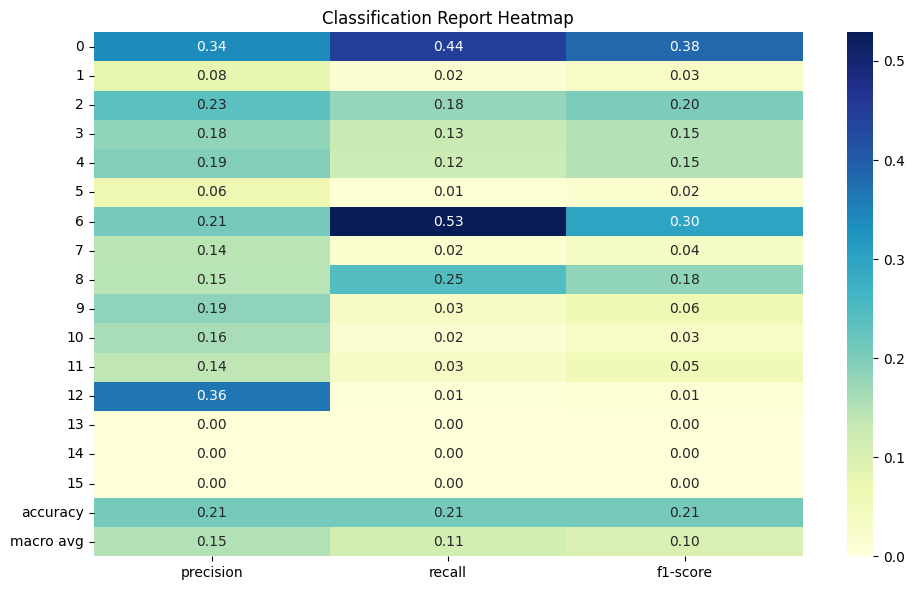

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.show()

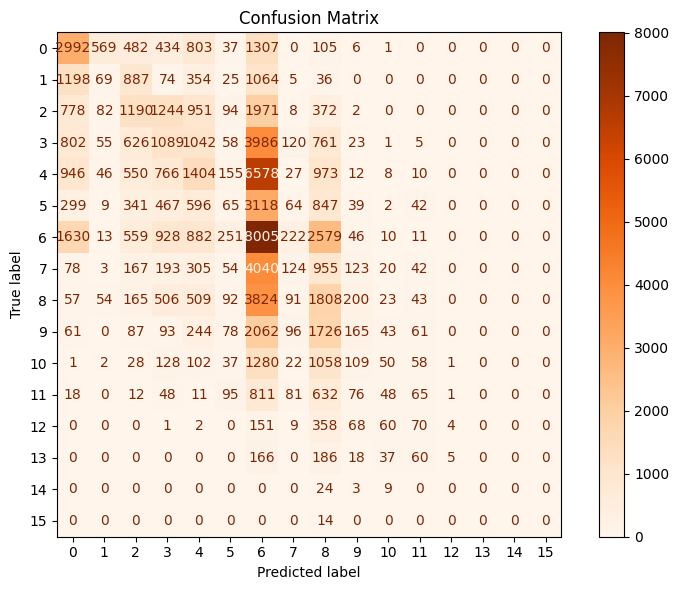

In [60]:
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[str(i) for i in range(len(report_df)-3)])
disp.plot(ax=ax, cmap="Oranges", values_format=".0f", colorbar=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

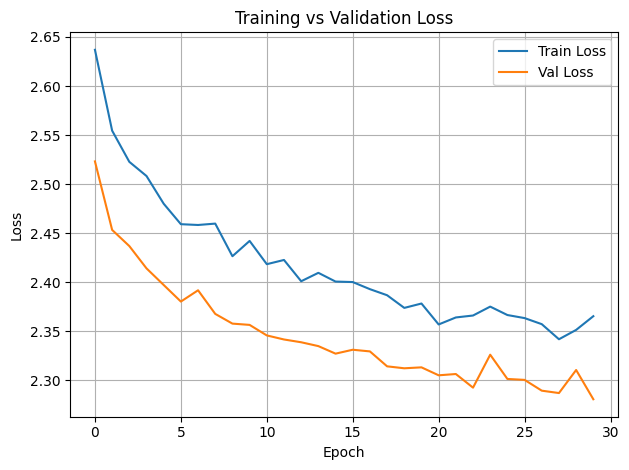

In [63]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

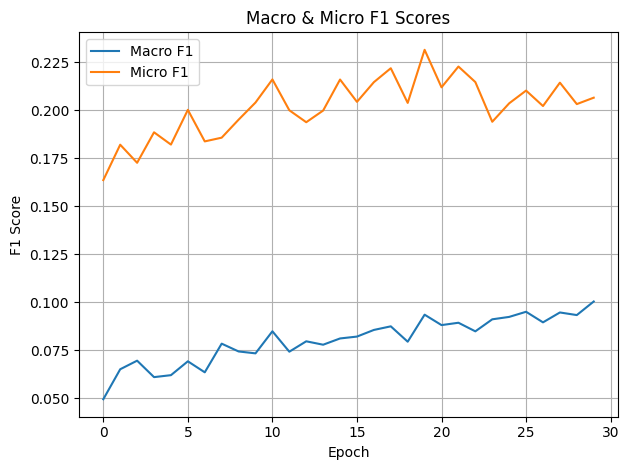

In [64]:
plt.figure()
plt.plot(history["macro_f1"], label="Macro F1")
plt.plot(history["micro_f1"], label="Micro F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Macro & Micro F1 Scores")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

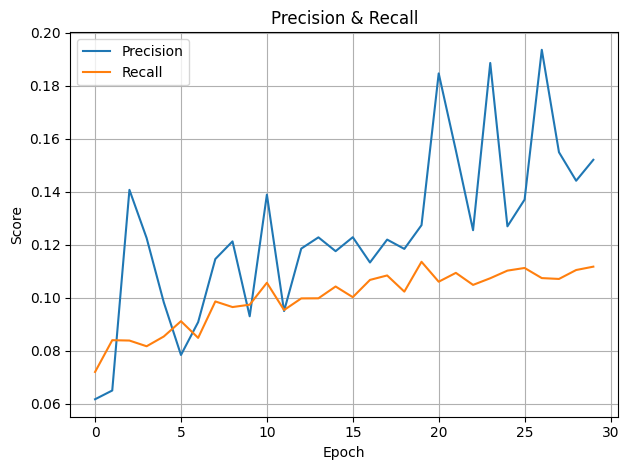

In [65]:
plt.figure()
plt.plot(history["precision"], label="Precision")
plt.plot(history["recall"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision & Recall")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

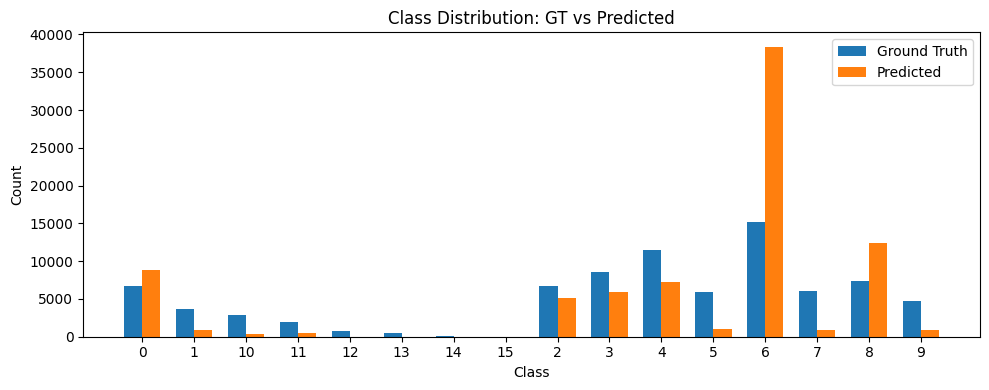

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Son epoch'taki dağılımları al
gt_dict = history["class_dist_gt"][-1]
pred_dict = history["class_dist_pred"][-1]

# Tüm sınıfları birleşik ve sıralı olarak al (birinde olup diğerinde olmayanlar olabilir)
all_classes = sorted(set(gt_dict.keys()).union(pred_dict.keys()))

# Eksik sınıflar için 0 değeri koy
gt_dist = [gt_dict.get(c, 0) for c in all_classes]
pred_dist = [pred_dict.get(c, 0) for c in all_classes]

# Bar grafiği çiz
x = np.arange(len(all_classes))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, gt_dist, width, label='Ground Truth')
plt.bar(x + width/2, pred_dist, width, label='Predicted')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution: GT vs Predicted")
plt.xticks(x, all_classes)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_targets, all_masks = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            cqt = batch['cqt'].to(device)      # [B,1,96,T]
            label = batch['label'].to(device)  # [B,6,T]
            mask = batch['mask'].to(device)    # [B,6,T]

            logits = model(cqt)                # [B,6,17,T]
            preds = torch.argmax(logits, dim=2)  # [B,6,T]

            all_preds.append(preds.cpu())
            all_targets.append(label.cpu())
            all_masks.append(mask.cpu())

    # Zaman eksenini hizala (ortak minimum T)
    T_min = min(p.shape[-1] for p in all_preds)
    preds = torch.cat([p[:, :, :T_min] for p in all_preds], dim=0)
    targets = torch.cat([t[:, :, :T_min] for t in all_targets], dim=0)
    masks = torch.cat([m[:, :, :T_min] for m in all_masks], dim=0)

    # Flatten ve maskele
    preds = preds.reshape(-1)
    targets = targets.reshape(-1)
    masks = masks.reshape(-1)

    valid_idx = masks == 1
    preds = preds[valid_idx].numpy()
    targets = targets[valid_idx].numpy()

    # Raporlar
    print("Classification Report:\n", classification_report(targets, preds, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(targets, preds))

    return preds, targets

In [68]:
evaluate_model(model, val_loader, DEVICE)

Classification Report:
               precision    recall  f1-score   support

           0      0.338     0.444     0.384      6736
           1      0.076     0.019     0.030      3712
           2      0.234     0.178     0.202      6692
           3      0.182     0.127     0.150      8568
           4      0.195     0.122     0.150     11475
           5      0.062     0.011     0.019      5889
           6      0.209     0.529     0.299     15136
           7      0.143     0.020     0.036      6104
           8      0.145     0.245     0.183      7372
           9      0.185     0.035     0.059      4716
          10      0.160     0.017     0.031      2876
          11      0.139     0.034     0.055      1898
          12      0.364     0.006     0.011       723
          13      0.000     0.000     0.000       472
          14      0.000     0.000     0.000        36
          15      0.000     0.000     0.000        14

    accuracy                          0.207     82419
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([0, 0, 0, ..., 4, 4, 4]), array([0, 0, 0, ..., 0, 0, 0]))